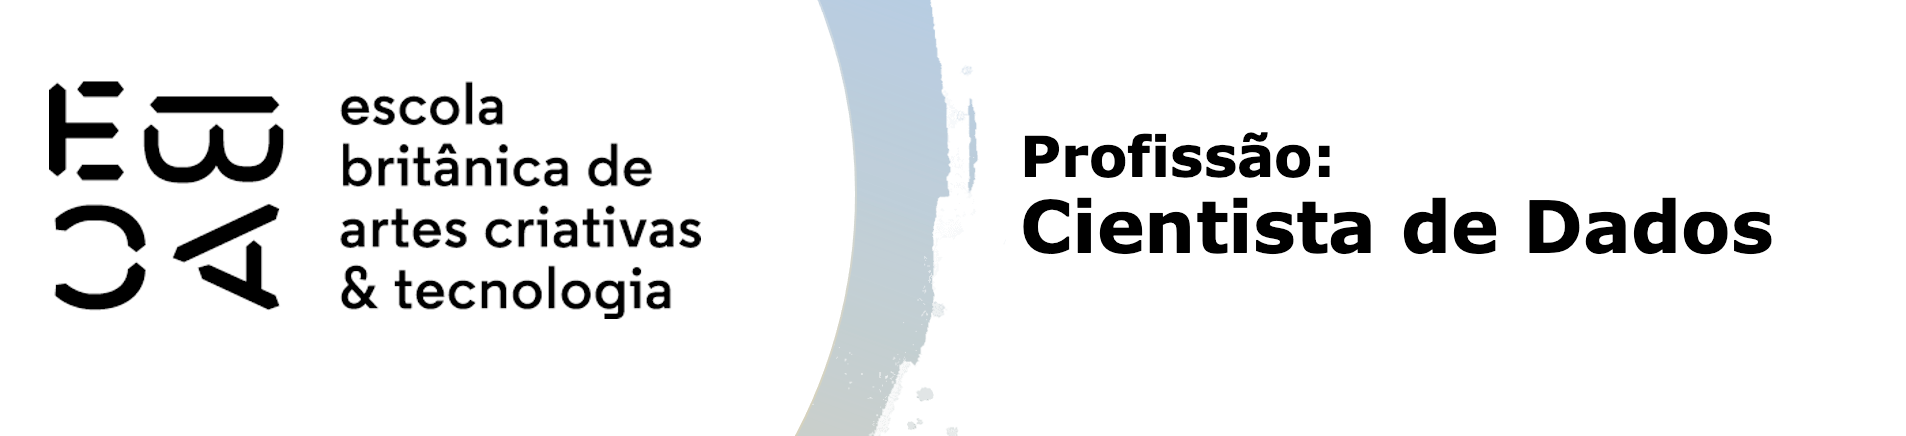

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
#Importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import plotly.express as px

from tabulate import tabulate

#Importar base de dados
df = pd.read_pickle('base_nfp.pkl')
df["Retorno_bol"] = df[["Retorno"]] > 0
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria,Retorno_bol
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado,False
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto,False
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes,True
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes,True
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes,True


In [2]:
print("Entre as colunas existentes na base de dados o CNPJ e o Emitente carregam a mesma informação então materei apenas uma (emitente), a coluna Nº também não se mostra importante para a análise, assim como data de registro, em que a data de emissão é o que se mostra mais importante. Por último o valor do Credito em si torna-se ineficiente diante ao valor de Retorno, então materei a penas o último citado. E considerando que queremos saber see há ou não a probabilidade de retorno não precisamos considerar o valor de Retorno e sim se houve ou não retorno (considerando a coluna criada Retorno_bol)")

df = df.drop(["CNPJ emit.", "No.", "Data Registro", "Créditos", "Retorno"], axis=1)

Entre as colunas existentes na base de dados o CNPJ e o Emitente carregam a mesma informação então materei apenas uma (emitente), a coluna Nº também não se mostra importante para a análise, assim como data de registro, em que a data de emissão é o que se mostra mais importante. Por último o valor do Credito em si torna-se ineficiente diante ao valor de Retorno, então materei a penas o último citado. E considerando que queremos saber see há ou não a probabilidade de retorno não precisamos considerar o valor de Retorno e sim se houve ou não retorno (considerando a coluna criada Retorno_bol)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187646 entries, 0 to 187645
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Emitente             187646 non-null  object        
 1   Data Emissão         187646 non-null  datetime64[ns]
 2   Valor NF             187646 non-null  float64       
 3   Situação do Crédito  187646 non-null  category      
 4   Ano                  187646 non-null  int64         
 5   Semestre             187646 non-null  int64         
 6   flag_credito         187646 non-null  int64         
 7   categoria            187646 non-null  object        
 8   Retorno_bol          187646 non-null  bool          
dtypes: bool(1), category(1), datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 10.4+ MB


In [4]:
df["Ano"].nunique()

5

## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [5]:
# Criando variáveis Temporais

df["Dia Mês"] = df["Data Emissão"].dt.strftime("%d")
df["Dia Semana"] = df["Data Emissão"].dt.strftime("%a")
df["Fim de Semana"] = df["Dia Semana"].isin(["Sat", "Sun"])
df["Mês"] = df["Data Emissão"].dt.strftime("%b")
df["Nº Mês"] = df["Data Emissão"].dt.strftime("%m").astype(int)
df["Trimestre"] = ((df["Nº Mês"] - 1) // 3) + 1
df["Trim-Ano"] = df["Ano"].astype(str) + "-Q" + df["Trimestre"].astype(str)

df.head()

,Emitente,Data Emissão,Valor NF,Situação do Crédito,Ano,Semestre,flag_credito,categoria,Retorno_bol,Dia Mês,Dia Semana,Fim de Semana,Mês,Nº Mês,Trimestre,Trim-Ano
0,DIA BRASIL SOCIEDADE LIMITADA,2017-06-30,24.68,Liberado,2017,1,0,Mercado,False,30,Fri,False,Jun,6,2,2017-Q2
1,AUTO POSTO ZANWAL LTDA EPP,2017-06-30,50.00,Liberado,2017,1,0,Auto posto,False,30,Fri,False,Jun,6,2,2017-Q2
2,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,2017-06-30,27.00,Liberado,2017,1,1,Restaurantes,True,30,Fri,False,Jun,6,2,2017-Q2
3,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,2017-06-30,111.50,Liberado,2017,1,1,Restaurantes,True,30,Fri,False,Jun,6,2,2017-Q2
4,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,2017-06-30,125.00,Liberado,2017,1,1,Restaurantes,True,30,Fri,False,Jun,6,2,2017-Q2


In [6]:
# Criando Categorização do Valor da Nota, criando por quarties
def quantiles(n_categories):
    quantiles = np.linspace(0, 1, n_categories + 1)
    bins = np.quantile(df["Valor NF"].dropna(), quantiles)
    bins = np.unique(bins)
    labels = range(1, len(bins))
    return pd.cut(df["Valor NF"], bins=bins, labels=labels, include_lowest=True)

# Categorias 5, 10, 20 e 50 
df["Q5"] = quantiles(5)
df["Q10"] = quantiles(10)
df["Q20"] = quantiles(20)
df["Q50"] = quantiles(50)

print(df[["Q5", "Q10", "Q20", "Q50"]].head())

  Q5 Q10 Q20 Q50
0  2   4   8  18
1  3   6  12  29
2  2   4   8  20
3  4   8  16  39
4  4   8  16  40


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [7]:
def IV(variavel_en, variavel_resp, df = df):
    tab = pd.crosstab(variavel_en, variavel_resp, margins=True, margins_name="total")

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab["pct_evento"] = tab[rótulo_evento] / tab.loc["total", rótulo_evento]
    tab["pct_nao_evento"] = tab[rótulo_nao_evento] / tab.loc["total", rótulo_nao_evento]
    
    #Caso 0
    tab["pct_evento"] = tab["pct_evento"].replace(0, 1e-6)
    tab["pct_nao_evento"] = tab["pct_nao_evento"].replace(0, 1e-6)
    
    tab["woe"] = np.log(tab["pct_evento"] / tab["pct_nao_evento"])
    tab["iv_parcial"] = (tab["pct_evento"] - tab["pct_nao_evento"]) * tab["woe"]

    return tab, tab["woe"], tab["iv_parcial"]

for variavel in [col for col in df.columns if df[col].nunique() <= 50]:
    if variavel != "Retorno_bol":   
        tab, woe, iv = IV(df[variavel], df["Retorno_bol"])  
        print(f"{variavel} - IV: {iv.sum():.4f}")


Situação do Crédito - IV: 0.0009
Ano - IV: 0.0417
Semestre - IV: 0.0013
flag_credito - IV: 27.6310
categoria - IV: 0.4083
Dia Mês - IV: 0.0437
Dia Semana - IV: 0.0069
Fim de Semana - IV: 0.0043
Mês - IV: 0.0278
Nº Mês - IV: 0.0278
Trimestre - IV: 0.0115
Trim-Ano - IV: 0.0797
Q5 - IV: 0.0567
Q10 - IV: 0.1066
Q20 - IV: 0.1245
Q50 - IV: 0.1523


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

O Information Value (IV) uma medida preditiva, é um indicador que mede o quanto uma variável é capaz de 'separar' individualmente eventos e não eventos. Consideramos como padrão a tabela de comparação desenvolvida por <i>Naeem Siddiqi</i> para decisão sobre a capacidade ou não de cada variável para predição:

<html lang="pt-BR">
<head>
  <meta charset="utf-8" />
  <meta name="viewport" content="width=device-width,initial-scale=1" />
</head>
<body>
  <div class="card" role="region" aria-label="Tabela de faixas e poder preditivo">
    <table>
      <thead>
        <tr>
          <th>Faixa</th>
          <th>Poder preditivo</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <td>0 a 0.02</td>
          <td><span class="badge inutil">Inútil</span></td>
        </tr>
        <tr>
          <td>0.02 a 0.1</td>
          <td><span class="badge fraco">Fraco</span></td>
        </tr>
        <tr>
          <td>0.1 a 0.3</td>
          <td><span class="badge medio">Médio</span></td>
        </tr>
        <tr>
          <td>0.3 a 0.5</td>
          <td><span class="badge forte">Forte</span></td>
        </tr>
        <tr>
          <td>0.5 ou mais</td>
          <td><span class="badge suspeito">Suspeito de tão alto</span></td>
        </tr>
      </tbody>
    </table>
  </div>
</body>
</html>



Situação do Crédito - IV: inf - Suspeito de tão alto <br>
Ano - IV: 0.0417 - Fraco<br>
Semestre - IV: 0.0013 - Inútil<br>
flag_credito - IV: inf - Suspeito de tão alto<br>
categoria - IV: 0.4083 - Forte<br>
Dia Mês - IV: 0.0437 - Forte<br>
Dia Semana - IV: 0.0069 - Inútil<br>
Fim de Semana - IV: 0.0043 - Inútil<br>
Mês - IV: 0.0278 - Fraco<br>
Nº Mês - IV: 0.0278 - Fraco<br>
Trimestre - IV: 0.0115 - Inútil<br>
Q5 - IV: 0.0567 - Fraco<br>
Q10 - IV: 0.1066 - Médio<br>
Q20 - IV: 0.1245 - Médio <br>
Q50 - IV: 0.1523 - Médio<br>

Podemos notar que Situação do Crédito e flag_credito tendem ao infinito, o que sugere um comportamento em que a probabilidade do não evento dessas variáveis é igual ou praticamente nula. Também notamos que um aumento de quantis melhora a análise do modelo, comportamente semelhante de quando analisamos as variáveis de data quanto maior o número de categorias na resposta (semestre, trimestre, ano) torna a moelagem mais forte. 

Variáveis que apresentam comportamento contínuo ou semelhante a ele tendem à ter melhor preditividade uma vez que há um corte melhor delimitadpo do evento e donão evento. 

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

Quantidade de notas registradas na base por período


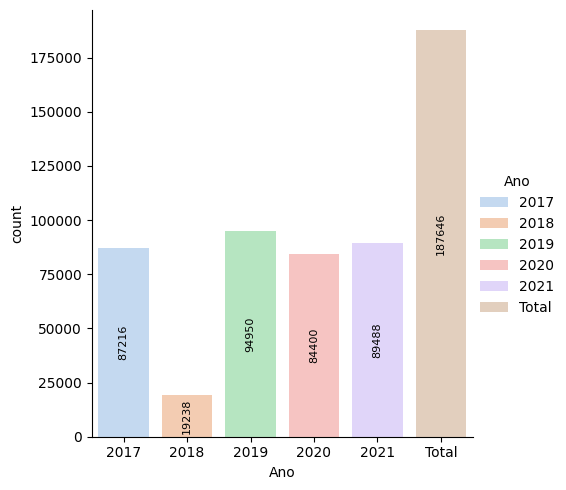

In [8]:
print("Quantidade de notas registradas na base por período")
df_total = df.copy()
df_total['Ano'] = 'Total'
df_total["Trim-Ano"] = 'Total'
df_total_ano = (
    df.groupby("Ano")
      .size()
      .reset_index(name="count")
)

df_total_ano_expanded = df_total_ano.loc[df_total_ano.index.repeat(df_total_ano["count"])].reset_index(drop=True)
df_total_ano_expanded["Trimestre"] = "Total"

df_combined = pd.concat([df, df_total, df_total_ano_expanded])
df_combined = df_combined.reset_index(drop=True) 
df_combined["Trim-Ano"] = df_combined["Trim-Ano"].astype(str)

ordemA = list(df["Ano"].unique()) + ["Total"]

fig = sns.catplot(
    data=df_combined,
    kind="count",
    x="Ano",
    hue="Ano",
    palette="pastel",
    alpha=.7,
    order=ordemA,
    height=5
)

# Labels dentro das barras
for ax in fig.axes[0]:
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(
                x=p.get_x() + p.get_width() / 2,
                y= (height/2),
                s=int(height),
                ha="center",
                va="center",
                fontsize=8,
                rotation="vertical"
            )

plt.show()

Podemos observar que não há um padrão constante de aumento ou redução nas notas com retorno ao longo dos anos. Há uma queda significativa entre 2017 e 2018, seguida por um aumento ainda mais expressivo entre 2018 e 2019, mantendo-se em níveis elevados a partir desse ano. No entanto, houve uma nova redução em 2020, com recuperação em 2021.

Quantidade de notas registradas na base por período


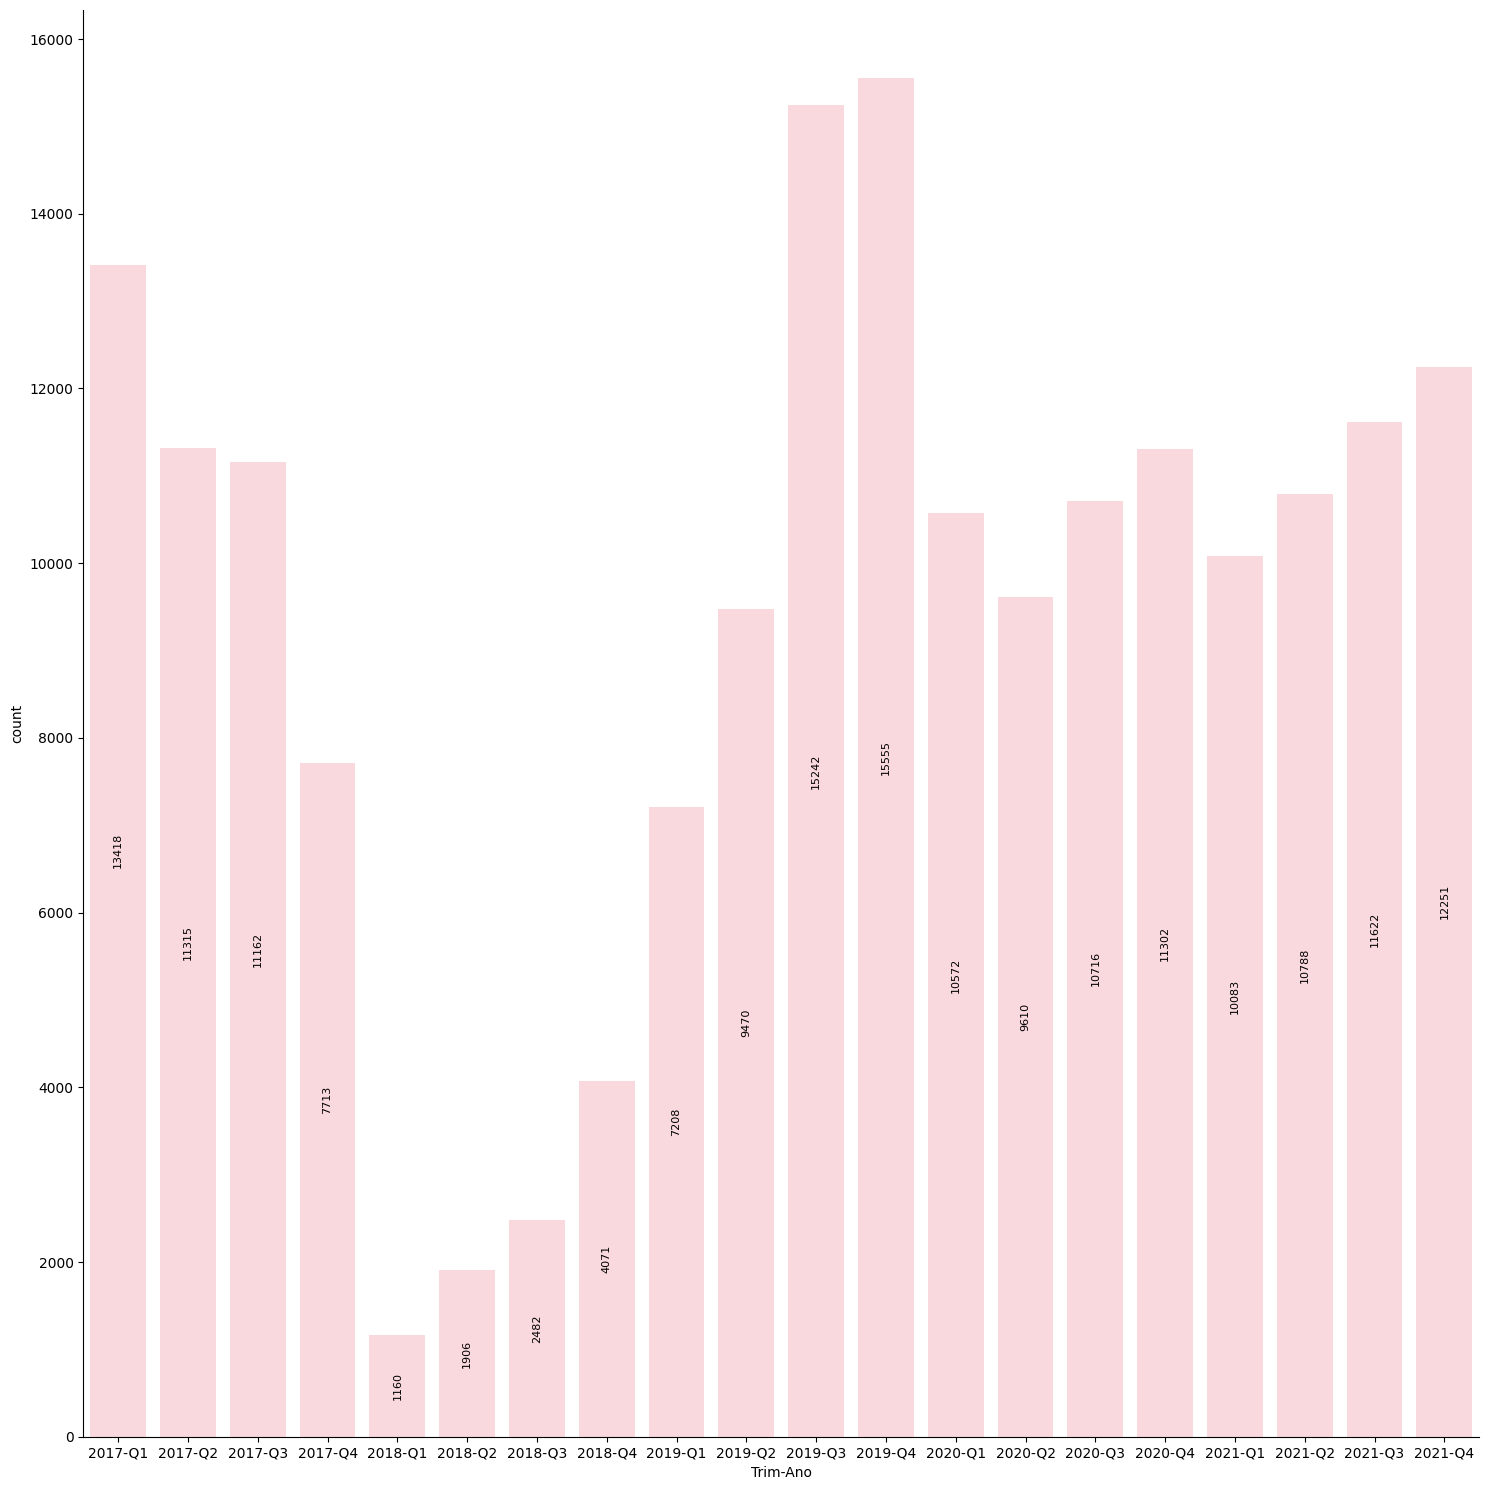

In [9]:
print("Quantidade de notas registradas na base por período")

ordem = sorted([x for x in df["Trim-Ano"].unique()])

fig1 = sns.catplot(
    data=df,
    kind="count",
    x="Trim-Ano",
    color = "pink",
    alpha=.7,
    order=ordem,
    height=15
)

# Labels dentro das barras
for ax in fig1.axes.flat:
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(
                x=p.get_x() + p.get_width() / 2,
                y= (height/2),
                s=int(height),
                ha="center",
                va="center",
                fontsize=8,
                rotation="vertical"
            )

plt.show()

Considerando a análise de notas com retorno percebemos, em praticamente todo o período analisado, um aumento durnate cada ano. A excessão a essa regr ocorre em 2017, provavelmente o ano em que o programa teve inicio e portanto podemos considerá-lo um período de experiência no qual é normal haver esse desinteresse após os primeiros meses. E em 2020 que houve uma redução entre Q1 e Q2, provavelmente isso acontece devido à pandemia de COVID-19, em que houve uma rdução no consumo e na confiança no mercado.

Quantidade de notas por categoria e por período


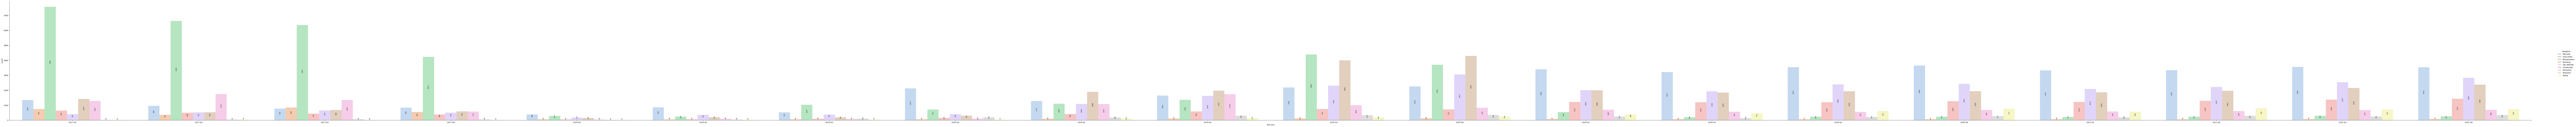

In [10]:
print("Quantidade de notas por categoria e por período")
totais = df.groupby('categoria').size().reset_index(name='total')

fig2 = sns.catplot(
    data=df,
    kind="count",
    x="Trim-Ano",
    hue="categoria",
    palette="pastel",
    alpha=.7,
    order=ordem,
    height=10,
    aspect=20
)

# Labels dentro das barras
for ax in fig2.axes[0]:
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(
                x=p.get_x() + p.get_width() / 2,
                y= (height+200)/2,
                s=int(height),
                ha="center",
                va="center",
                fontsize=8,
                rotation="vertical"
            )

plt.show()

Na análise quantitativa, observamos um número significativamente maior de notas com retorno no ano de 2017, em comparação às demais categorias. A partir de 2018, verifica-se uma maior uniformidade nessa distribuição, com quantidades mais próximas entre as categorias. Em 2019, destaca-se um salto relevante no volume de notas com retorno provenientes de farmácias. Por outro lado, as compras em auto posto, vestuário, varejo e alimentos mantêm-se entre as categorias com menores valores ao longo do período analisado.

Proporção de notas com crédito por categoria por período


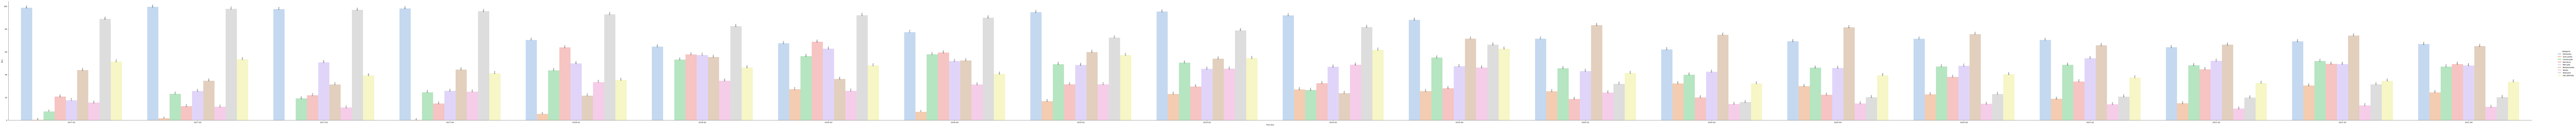

In [11]:
print("Proporção de notas com crédito por categoria por período")

perc = (df.groupby(["Trim-Ano", "categoria"])["Retorno_bol"].mean().reset_index())
perc["Perc"] = perc["Retorno_bol"]*100

fig3 = sns.catplot(
    data=perc,
    kind="bar",
    x="Trim-Ano",
    y = "Perc",
    hue="categoria",
    palette="pastel",
    alpha=.7,
    order=ordem,
    height=10,
    aspect=20
)

# Labels dentro das barras
for ax in fig3.axes[0]:
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(
                x=p.get_x() + p.get_width() / 2,
                y= (height+1),
                s=f"{int(height)}%",
                ha="center",
                va="center",
                fontsize=8,
                rotation="vertical"
            )

plt.show()

Entre os gráficos dos períodos analisados, identificamos um comportamento semelhante no desenho das curvas, embora não seja constante ou proporcional. Ao longo de todo o período, destaca-se a alta participação das notas com retorno da categoria alimentos, seguidas, em geral, por vestuário ou restaurantes.

Em 2017, o volume de notas de alimentos e vestuário apresentou-se especialmente elevado. Já em 2018, houve uma leve redução em alimentos, enquanto vestuário se manteve em patamares altos, possivelmente impulsionado pela expansão do comércio eletrônico de grandes varejistas online (como Shein e Shopee).

A partir de 2019, observa-se uma substituição gradual no retorno de vestuário por restaurantes, fenômeno que pode estar relacionado ao contexto da pandemia. Nesse mesmo período, destaca-se ainda o aumento na proporção de retornos em farmácias, que se manteve relativamente estável até o último período analisado.

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

Para o caso estudado temos o total de WOE igual a  1.58407 e o de IV igual a  0.29634
Então o gráfico o qual é possível calcular de ambos os dados ao longo do tempor categoria é


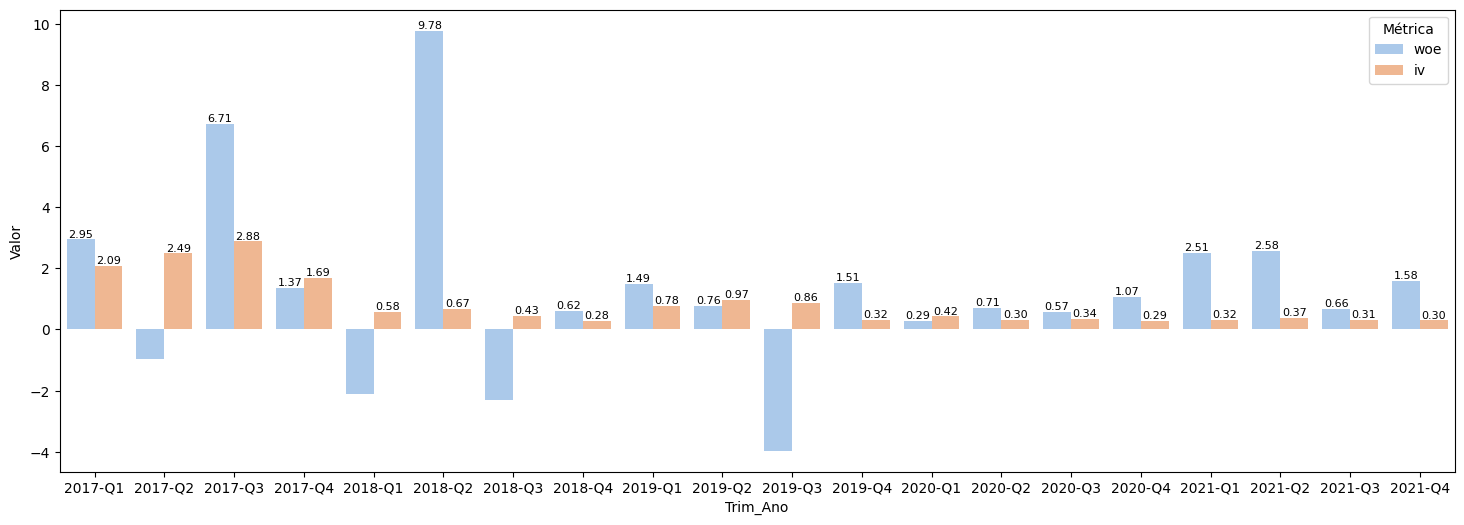

In [12]:
# Para analisarmos ambas variáveis no tempo utilizaremos novamente os dados caculados na função IV definida anteriormente.
# Para isso passaremos a variável como categoiria

resp_cat = []
quart = sorted(df["Trim-Ano"].unique())

for i in quart:
    sub = df[df["Trim-Ano"] == i].copy()
    try:
        tab_cat, woe_cat, iv_cat = IV(sub["categoria"], sub["Retorno_bol"])
    except Exception as E:
        print("Erro ao quebrar no período")
        continue
    
    woe_cat = pd.Series(woe_cat)
    iv_cat = pd.Series(iv_cat)
    
    props = sub["categoria"].value_counts(normalize = True).reindex(woe_cat.index).fillna(0)
    resp_cat.append({
        "Trim_Ano": i,
        "woe": float(woe_cat.sum()),
        "iv": float(iv_cat.sum())})
    
df_resp = pd.DataFrame(resp_cat).sort_values("Trim_Ano")

print(f"Para o caso estudado temos o total de WOE igual a {woe_cat.sum(): .5f} e o de IV igual a {iv_cat.sum(): .5f}")

print("Então o gráfico o qual é possível calcular de ambos os dados ao longo do tempor categoria é")

df_melt = df_resp.melt(id_vars="Trim_Ano", value_vars=["woe", "iv"], var_name="Métrica", value_name="Valor")

fig, ax = plt.subplots(figsize=(18,6))
sns.barplot(data=df_melt, x="Trim_Ano", y="Valor", hue="Métrica", palette="pastel", ax=ax)

# Rótulos nas barras
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + 0.01,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=8
        )

plt.show()

Em relação ao Information Value (IV), observamos um comportamento pouco consistente, mantendo-se acima de 0,5 até o último trimestre de 2019. No geral, seu valor global indica uma confiabilidade média para predição, próxima da classificação de 'forte'.
Quanto ao Weight of Evidence (WOE), verificamos uma elevada variabilidade ao longo do tempo. Em alguns trimestres o índice assume valores negativos, embora, na maior parte do período, permaneça positivo.
Esses resultados sugerem que as variáveis categoria, data e retorno apresentam uma relação relevante para a predição dos resultados futuros do programa.

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

De forma conclusiva, identificamos que as categorias alimentos, vestuário e, a partir de 2019, restaurantes concentram as maiores proporções de notas com retorno superior a zero, com destaque adicional para o crescimento da participação de farmácias ao longo do período. Essas diferenças, entretanto, não se mostraram totalmente estáveis no tempo: enquanto em alguns anos há uma predominância clara de determinadas categorias, em outros ocorre uma redistribuição significativa entre elas, influenciada por fatores externos, como a expansão do comércio eletrônico e a pandemia de COVID-19. Assim, embora haja padrões recorrentes, as variações temporais indicam que o comportamento das categorias não segue uma tendência linear, mas sim dinâmica e sensível ao contexto de cada período.